In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.tree import DecisionTreeClassifier  
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV 
from sklearn.metrics import (confusion_matrix, precision_score,recall_score,
                              classification_report,make_scorer,fbeta_score,roc_auc_score) 
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
import xgboost
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv(r'/Users/satyasriallaka/Documents/accenture_ml_problem/Task2- Training_Dataset.csv')
test = pd.read_csv(r'/Users/satyasriallaka/Documents/accenture_ml_problem/Task2- Test_Dataset_OOS.csv')
train.head()

,Var0,Var1,Var7,Var8,Var9,Var10,Var6,Var11,Var5,Var3,Var4,Var2
0,127899,0,8,0,0,1,0,0,60212.0,63,0,0.351737
1,146311,0,16,0,1,0,0,0,49112.0,52,2,0.895729
2,19362,0,4,0,1,0,0,0,25801.0,48,0,0.108889
3,63856,0,3,0,0,0,0,0,25033.0,66,0,0.000000
4,66930,1,13,1,0,1,0,0,20809.0,94,1,0.063049


In [3]:
train.rename(columns={'Var0':'cust_id','Var1':'target','Var2':'line_of_credit','Var3':'age',
                      'Var4':'delinquency_30days','Var5':'iir','Var6':'income',
                      'Var7':'open_loans','Var8':'delinquency_90days',
                      'Var9':'mortagage','Var10':'delinquency_60days',
                      'Var11':'dependents'},inplace=True)
train.head()

,cust_id,target,open_loans,delinquency_90days,mortagage,delinquency_60days,income,dependents,iir,age,delinquency_30days,line_of_credit
0,127899,0,8,0,0,1,0,0,60212.0,63,0,0.351737
1,146311,0,16,0,1,0,0,0,49112.0,52,2,0.895729
2,19362,0,4,0,1,0,0,0,25801.0,48,0,0.108889
3,63856,0,3,0,0,0,0,0,25033.0,66,0,0.000000
4,66930,1,13,1,0,1,0,0,20809.0,94,1,0.063049


event rate is 6%

In [4]:
train['target'].value_counts(normalize=True)

0    0.93316
1    0.06684
Name: target, dtype: float64

In [5]:
train['target'] = train['target'].astype(str)
train['target'].unique()

array(['0', '1'], dtype=object)

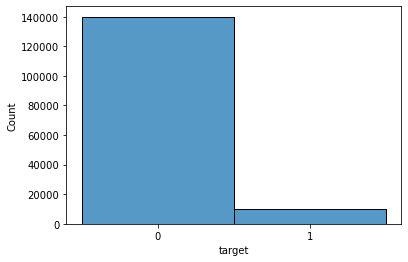

In [6]:
sns.histplot(data=train,x='target')
train['target'] = train['target'].astype(int)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   cust_id             150000 non-null  int64  
 1   target              150000 non-null  int64  
 2   open_loans          150000 non-null  int64  
 3   delinquency_90days  150000 non-null  int64  
 4   mortagage           150000 non-null  int64  
 5   delinquency_60days  150000 non-null  int64  
 6   income              150000 non-null  object 
 7   dependents          150000 non-null  object 
 8   iir                 150000 non-null  float64
 9   age                 150000 non-null  int64  
 10  delinquency_30days  150000 non-null  int64  
 11  line_of_credit      150000 non-null  float64
dtypes: float64(2), int64(8), object(2)
memory usage: 13.7+ MB


In [8]:
train.describe()

,cust_id,target,open_loans,delinquency_90days,mortagage,delinquency_60days,iir,age,delinquency_30days,line_of_credit
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,75000.500000,0.066840,8.452760,0.265973,1.018240,0.240387,353.005076,52.295207,0.421033,6.048438
std,43301.414527,0.249746,5.145951,4.169304,1.129771,4.155179,2037.818523,14.771866,4.192781,249.755371
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,5.000000,0.000000,0.000000,0.000000,0.175074,41.000000,0.000000,0.029867
50%,75000.500000,0.000000,8.000000,0.000000,1.000000,0.000000,0.366508,52.000000,0.000000,0.154181
75%,112500.250000,0.000000,11.000000,0.000000,2.000000,0.000000,0.868254,63.000000,0.000000,0.559046
max,150000.000000,1.000000,58.000000,98.000000,54.000000,98.000000,329664.000000,109.000000,98.000000,50708.000000


3924 customers have no available dependets information

In [9]:
train['dependents'].unique()

array([0, 3, 1, 2, 4, 5, 10, 7, 6, 8, 9, 13, '0', '1', '2', '3', '6', '4',
       '5', '7', '8', '20', '10', '9', 'Not Available'], dtype=object)

In [10]:
train['delinquency_90days'].value_counts().head(8)

0     141662
1       5243
2       1555
3        667
4        291
98       264
5        131
6         80
Name: delinquency_90days, dtype: int64

29731 customers has no income available information

In [11]:
train['income'].unique()

array([0, 1, 2, ..., '1794060', '3008750', 'Not Available'], dtype=object)

1 customer has age zero

In [12]:
train['age'][train['age']!=0].describe()

count    149999.000000
mean         52.295555
std          14.771298
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

In [13]:
train['mortagage'].value_counts()

0     56188
1     52338
2     31522
3      6300
4      2170
5       689
6       320
7       171
8        93
9        78
10       37
11       23
12       18
13       15
15        7
14        7
17        4
16        4
25        3
18        2
23        2
20        2
19        2
54        1
21        1
26        1
29        1
32        1
Name: mortagage, dtype: int64

<AxesSubplot:>

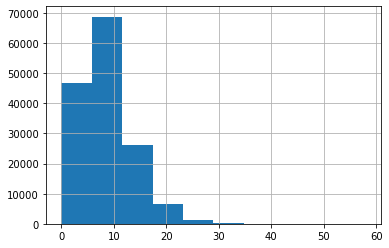

In [14]:
train['open_loans'].hist()

iir and balance on lines of credit are on percentage (%)

In [15]:
# train['iir'] = train['iir']/100
# train['line_of_credit'] = train['line_of_credit']/100

In [16]:
train['line_of_credit'].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: line_of_credit, dtype: float64

In [17]:
train.loc[train['dependents']=='Not Available','dependents'] = -99
train.loc[train['income']=='Not Available','income'] = -99
train['income'] = train['income'].astype(int)

train['dependents'] = train['dependents'].astype(int)


In [18]:
train[['age','target']][train['dependents']==0].value_counts()

age  target
63   0         2548
62   0         2351
61   0         2265
64   0         2119
60   0         2091
               ... 
94   1            1
93   1            1
99   1            1
101  1            1
107  0            1
Length: 158, dtype: int64

<AxesSubplot:xlabel='target', ylabel='delinquency_90days'>

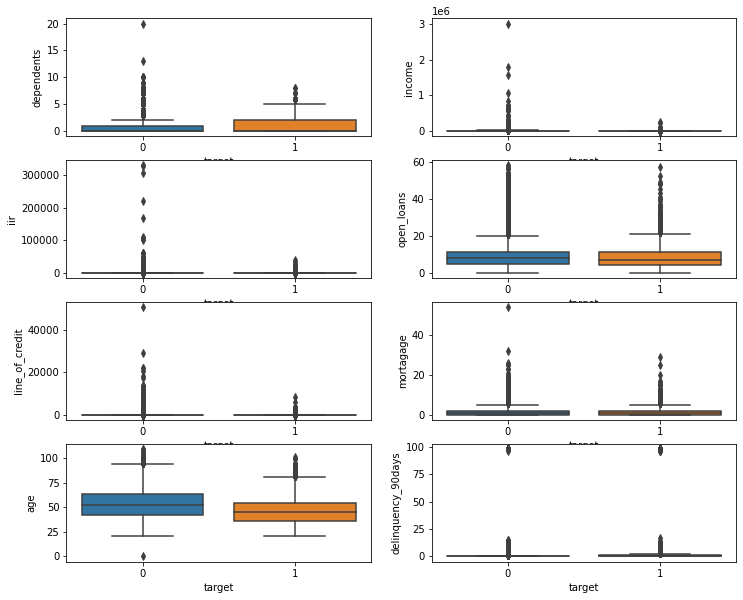

In [19]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,10))
sns.boxplot(data=train[train['dependents']>=0], x='target',y='dependents', ax=ax[0][0])
sns.boxplot(data=train, x='target',y='income', ax=ax[0][1])
sns.boxplot(data=train, x='target',y='iir', ax=ax[1][0])
sns.boxplot(data=train, x='target',y='open_loans', ax=ax[1][1])
sns.boxplot(data=train, x='target',y='line_of_credit', ax=ax[2][0])
sns.boxplot(data=train, x='target',y='mortagage', ax=ax[2][1])
sns.boxplot(data=train, x='target',y='age', ax=ax[3][0])
sns.boxplot(data=train, x='target',y='delinquency_90days', ax=ax[3][1])

# correlation

In [20]:
correlation = train.corr(method='pearson')
columns = correlation.nlargest(20, 'target').index
columns

Index(['target', 'delinquency_30days', 'delinquency_90days',
       'delinquency_60days', 'dependents', 'cust_id', 'line_of_credit',
       'mortagage', 'iir', 'income', 'open_loans', 'age'],
      dtype='object')

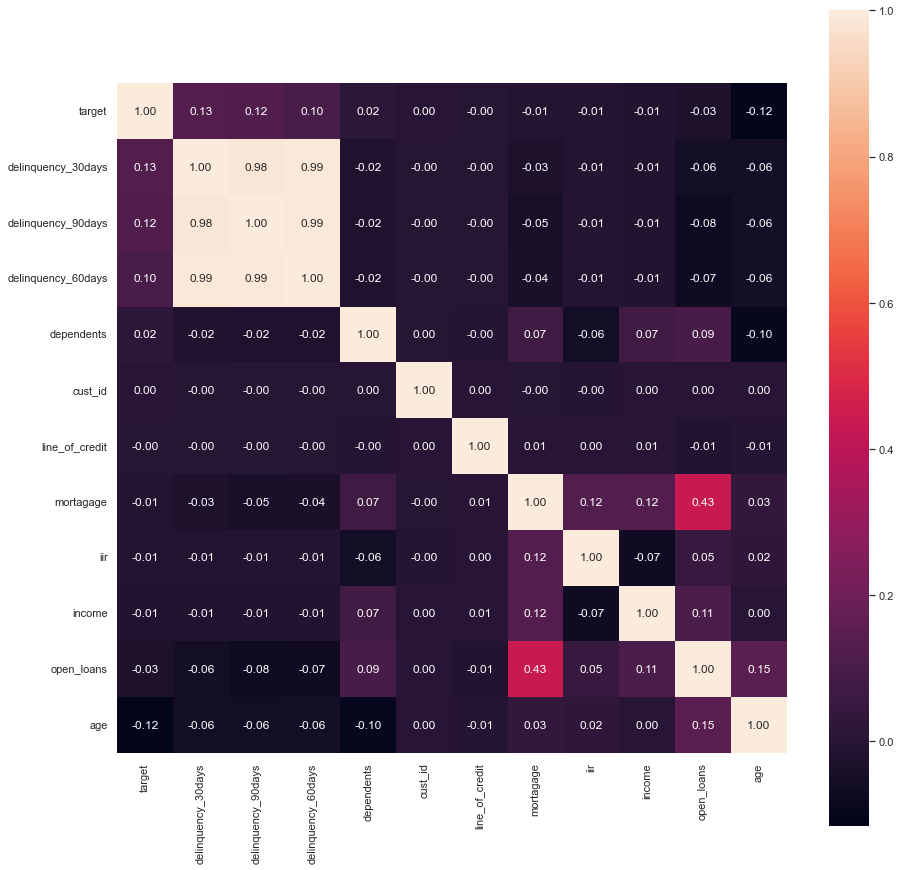

In [21]:
plt.figure(figsize=(15,15)) 
correlation_map = np.corrcoef(train[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

# feature engineering

# delinquency

delinquency in the past for 90 days, delinquency of 60,30 days but not in the last 2 years as binary features

In [22]:
train['delinquency_90days'].loc[train['delinquency_90days']>0] = 1
train['delinquency_90days'].value_counts()

0    141662
1      8338
Name: delinquency_90days, dtype: int64

In [23]:
train['delinquency_60days'].loc[train['delinquency_60days']>0] = 1
train['delinquency_60days'].value_counts()

0    142396
1      7604
Name: delinquency_60days, dtype: int64

In [24]:
train['delinquency_30days'].loc[train['delinquency_30days']>0] = 1
train['delinquency_30days'].value_counts()

0    126018
1     23982
Name: delinquency_30days, dtype: int64

In [25]:
train[['delinquency_90days','delinquency_60days','delinquency_30days','target']].corr()

,delinquency_90days,delinquency_60days,delinquency_30days,target
delinquency_90days,1.000000,0.314391,0.239439,0.339577
delinquency_60days,0.314391,1.000000,0.263461,0.275219
delinquency_30days,0.239439,0.263461,1.000000,0.246334
target,0.339577,0.275219,0.246334,1.000000


# age

<AxesSubplot:>

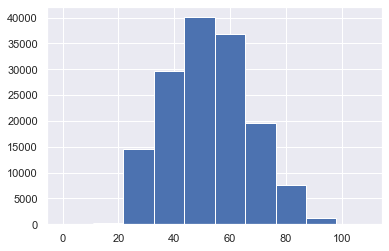

In [26]:
train['age'].hist()

<AxesSubplot:>

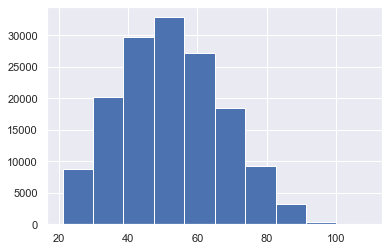

In [27]:
train.loc[train['age']==0,'age'] = train['age'].mode()[0]
train['age'].hist()

# Mortagage and real estate loans as binary

In [28]:
train['mortagage'].describe()

count    150000.000000
mean          1.018240
std           1.129771
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: mortagage, dtype: float64

In [29]:
train.loc[train['mortagage']>=1,'mortagage1'] = 1
train['mortagage1'].fillna(0,inplace=True)
train['mortagage1'].value_counts()

1.0    93812
0.0    56188
Name: mortagage1, dtype: int64

# open loans

In [30]:
train['open_loans'].describe()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: open_loans, dtype: float64

In [31]:
bins = [-1,5,8,11,60]
labels = ['low','medium','high','very_high']
train['open_loans_credit'] = pd.cut(train['open_loans'],bins=bins,labels=labels)
train['open_loans_credit'].value_counts()

low          46590
medium       39421
very_high    34689
high         29300
Name: open_loans_credit, dtype: int64

# iir

In [32]:
train['loan_per_dti'] = train['iir']/train['mortagage']
train[['loan_per_dti','iir','mortagage','target']].corr()

,loan_per_dti,iir,mortagage,target
loan_per_dti,1.000000,0.844309,-0.038758,-0.011987
iir,0.844309,1.000000,0.120046,-0.007602
mortagage,-0.038758,0.120046,1.000000,-0.007038
target,-0.011987,-0.007602,-0.007038,1.000000


In [33]:
train['loan_per_dti'][train['loan_per_dti']==np.inf] = 0
train.loc[train['loan_per_dti'].isnull(),'loan_per_dti'] = 0

# dependents

In [34]:
train['dependents'][train['dependents']<0] = 0
train['dependents'].value_counts()

0     90826
1     26316
2     19522
3      9483
4      2862
5       746
6       158
7        51
8        24
10        5
9         5
13        1
20        1
Name: dependents, dtype: int64

# income as categorical variable

replacing null values with median income

In [36]:
train['income'][train['income']>0].median()

5437.0

In [37]:
train.loc[train['income']<0,'income'] = 5437
train['income'].describe()

count    1.500000e+05
mean     6.425789e+03
std      1.288982e+04
min      0.000000e+00
25%      3.903000e+03
50%      5.437000e+03
75%      7.400000e+03
max      3.008750e+06
Name: income, dtype: float64

In [38]:
train['income'] = train['income'].astype(int)
train['income'].dtype
bins = [-1,3903,5437,7400,np.inf]
labels = ['low','medium','high','very_high']
train['income1'] = pd.cut(train['income'],bins=bins,labels=labels)
train['income1'].value_counts()

medium       53181
low          37503
very_high    37329
high         21987
Name: income1, dtype: int64

In [42]:
train.columns

Index(['cust_id', 'target', 'open_loans', 'delinquency_90days', 'mortagage',
       'delinquency_60days', 'income', 'dependents', 'iir', 'age',
       'delinquency_30days', 'line_of_credit', 'mortagage1',
       'open_loans_credit', 'loan_per_dti', 'income1'],
      dtype='object')

In [44]:
def encode_and_bind(original_dataframe,features_to_encode):
    dummies = pd.get_dummies(original_dataframe[[features_to_encode]])
    res = pd.concat([original_dataframe,dummies],axis=1)
    return res
train = encode_and_bind(train,'income1')
train = encode_and_bind(train,'open_loans_credit')

In [46]:
train.columns

Index(['cust_id', 'target', 'open_loans', 'delinquency_90days', 'mortagage',
       'delinquency_60days', 'income', 'dependents', 'iir', 'age',
       'delinquency_30days', 'line_of_credit', 'mortagage1',
       'open_loans_credit', 'loan_per_dti', 'income1', 'income1_low',
       'income1_medium', 'income1_high', 'income1_very_high',
       'open_loans_credit_low', 'open_loans_credit_medium',
       'open_loans_credit_high', 'open_loans_credit_very_high'],
      dtype='object')

In [47]:
drop_cols = ['iir','income','open_loans','mortagage','income1','open_loans_credit']
train.drop(drop_cols,axis=1,inplace=True)

In [48]:
train.columns

Index(['cust_id', 'target', 'delinquency_90days', 'delinquency_60days',
       'dependents', 'age', 'delinquency_30days', 'line_of_credit',
       'mortagage1', 'loan_per_dti', 'income1_low', 'income1_medium',
       'income1_high', 'income1_very_high', 'open_loans_credit_low',
       'open_loans_credit_medium', 'open_loans_credit_high',
       'open_loans_credit_very_high'],
      dtype='object')

In [55]:
train.isnull().sum()

cust_id                        0
target                         0
delinquency_90days             0
delinquency_60days             0
dependents                     0
age                            0
delinquency_30days             0
line_of_credit                 0
mortagage1                     0
loan_per_dti                   0
income1_low                    0
income1_medium                 0
income1_high                   0
income1_very_high              0
open_loans_credit_low          0
open_loans_credit_medium       0
open_loans_credit_high         0
open_loans_credit_very_high    0
dtype: int64

In [68]:
X = train.drop(['cust_id','target'],axis=1)
y = train[['target']]

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.25, random_state=123,
                                                   stratify=y)  

In [69]:
X_train.head()

,delinquency_90days,delinquency_60days,dependents,age,delinquency_30days,line_of_credit,mortagage1,loan_per_dti,income1_low,income1_medium,income1_high,income1_very_high,open_loans_credit_low,open_loans_credit_medium,open_loans_credit_high,open_loans_credit_very_high
57409,0,0,0,73,0,0.013647,0.0,0.000000,0,1,0,0,0,0,0,1
40748,0,0,2,33,0,0.775746,1.0,0.372191,0,1,0,0,0,0,1,0
46674,0,0,0,53,0,0.861428,1.0,0.418463,0,1,0,0,0,0,0,1
111885,0,0,4,52,0,0.118194,1.0,0.181448,0,0,0,1,1,0,0,0
6431,0,0,1,46,0,0.996109,0.0,0.000000,1,0,0,0,1,0,0,0


LR: 0.934756 (0.001312)
CART: 0.897493 (0.001975)
NB: 0.903076 (0.003550)
GBM: 0.931396 (0.001959)
[20:12:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:12:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:12:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:13:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' wa

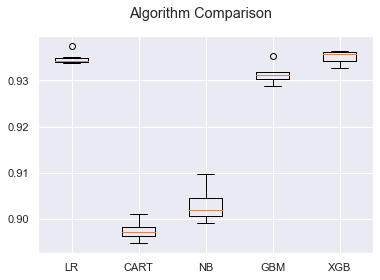

In [57]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import fbeta_score,make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('GBM',RandomForestClassifier()))
models.append(('XGB',XGBClassifier()))
# evaluate each model in turn
results = []
names = []
ftwo_scorer = make_scorer(fbeta_score,beta=0.5)
score='f1_macro'
for name, model in models:
    kfold = model_selection.KFold(n_splits=6, random_state=seed,shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_micro')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Xgboost hyper parameter tuning

In [70]:
#XGBOOST
xgb = XGBClassifier(max_depth=5,n_estimators=1500,scale_pos_weight=10)
xgb.fit(X_train, y_train)
y_train_hat = xgb.predict(X_train)
y_test_hat = xgb.predict(X_test)

print(xgb)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))

[19:21:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1500, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Train performance
-------------------------------------------------------
              precision    recall 

In [71]:
train['target'].value_counts()

0    139974
1     10026
Name: target, dtype: int64

In [72]:
139974/10026

13.961101137043686

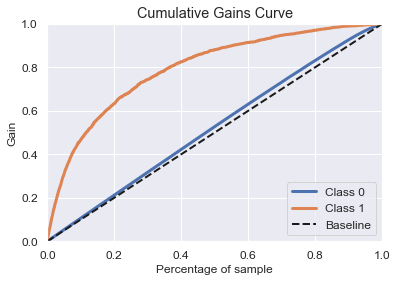

In [73]:
#gain curve
import scikitplot as skplt
predict_prob = xgb.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test,predict_prob)
plt.show()

In [76]:
from sklearn import model_selection
params = {
    'n_estimators': [100, 500,1000,1500],
    'learning_rate': [0.01,0.05,0.1],
#    'scale_pos_weight':[5,10,15,20],
    'alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

gs2 = RandomizedSearchCV(XGBClassifier(n_jobs=-1,scale_pos_weight=13,booster='gbtree'), params, n_jobs=-1, cv=model_selection.KFold(n_splits=5), scoring='roc_auc')
gs2.fit(X_train, y_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/satyasriallaka/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when construct

/Users/satyasriallaka/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/satyasriallaka/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1250, in fit
    self._Booster = train(
  File "/opt/anaconda3/lib/python3.9/site-packages/xgboost/training.py", line 188, in train
    bst = _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.9/site-packages/xgboost/training.py", line 81, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anaconda3/lib/python3.9/site-packages/xgb

  [bt] (4) 5   libxgboost.dylib                    0x000000013011bf47 XGBoosterUpdateOneIter + 151
  [bt] (5) 6   libffi.7.dylib                      0x000000010a767ead ffi_call_unix64 + 85
  [bt] (6) 7   ???                                 0x000000030347ba70 0x0 + 12939934320



  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/satyasriallaka/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/satyasriallaka/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when construct

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/satyasriallaka/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when construct

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/satyasriallaka/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/satyasriallaka/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/satyasriallaka/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/satyasriallaka/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File 

[19:41:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.8541818209108165
Best score: {'reg_lambda': 1, 'n_estimators': 100, 'learning_rate': 0.05, 'base_score': 0.5, 'alpha': 1}
[19:26:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:34:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:26:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used wi

In [77]:
y_train_hat = gs2.predict(X_train)
y_test_hat = gs2.predict(X_test)

#print(xgb)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))

Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.80      0.88    104980
           1       0.22      0.78      0.34      7520

    accuracy                           0.80    112500
   macro avg       0.60      0.79      0.61    112500
weighted avg       0.93      0.80      0.85    112500

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     34994
           1       0.22      0.76      0.34      2506

    accuracy                           0.80     37500
   macro avg       0.60      0.78      0.61     37500
weighted avg       0.93      0.80      0.85     37500

Roc_auc score
-------------------------------------------------------
0.7833507634486286

Confusion matrix
-------------------------------------------------------
[[28056  6938]
 [  589  1917]]


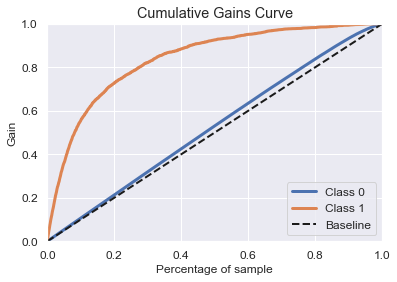

In [78]:
#gain curve
import scikitplot as skplt
predict_prob = gs2.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test,predict_prob)
plt.show()

# test prediction

In [79]:
test.rename(columns={'Var0':'cust_id','Var1':'target','Var2':'line_of_credit','Var3':'age',
                      'Var4':'delinquency_30days','Var5':'iir','Var6':'income',
                      'Var7':'open_loans','Var8':'delinquency_90days',
                      'Var9':'mortagage','Var10':'delinquency_60days',
                      'Var11':'dependents'},inplace=True)

In [84]:
test.loc[test['dependents']=='Not Available','dependents'] = -99
test.loc[test['income']=='Not Available','income'] = -99
test['income'] = test['income'].astype(int)

test['dependents'] = test['dependents'].astype(int)


test['delinquency_90days'].loc[test['delinquency_90days']>0] = 1
test['delinquency_60days'].loc[test['delinquency_60days']>0] = 1
test['delinquency_30days'].loc[test['delinquency_30days']>0] = 1

test.loc[test['age']==0,'age'] = test['age'].mode()[0]

In [88]:
test.loc[test['mortagage']>=1,'mortagage1'] = 1
test['mortagage1'].fillna(0,inplace=True)
test['mortagage1'].value_counts()

1.0    63437
0.0    38066
Name: mortagage1, dtype: int64

In [90]:
bins = [-1,5,8,11,100]
labels = ['low','medium','high','very_high']
test['open_loans_credit'] = pd.cut(test['open_loans'],bins=bins,labels=labels)
test['open_loans_credit'].value_counts()

low          31428
medium       26794
very_high    23356
high         19925
Name: open_loans_credit, dtype: int64

In [91]:
test['loan_per_dti'] = test['iir']/test['mortagage']

test['loan_per_dti'][test['loan_per_dti']==np.inf] = 0
test.loc[test['loan_per_dti'].isnull(),'loan_per_dti'] = 0

test['dependents'][test['dependents']<0] = 0
test.loc[test['income']<0,'income'] = 5437
test['income'] = test['income'].astype(int)
bins = [-1,3903,5437,7400,np.inf]
labels = ['low','medium','high','very_high']
test['income1'] = pd.cut(test['income'],bins=bins,labels=labels)
test['income1'].value_counts()

In [95]:
test = encode_and_bind(test,'income1')
test = encode_and_bind(test,'open_loans_credit')
test.columns

Index(['cust_id', 'target', 'delinquency_30days', 'income', 'open_loans',
       'delinquency_90days', 'delinquency_60days', 'dependents', 'age', 'iir',
       'mortagage', 'line_of_credit', 'mortagage1', 'open_loans_credit',
       'loan_per_dti', 'income1', 'income1_low', 'income1_medium',
       'income1_high', 'income1_very_high', 'open_loans_credit_low',
       'open_loans_credit_medium', 'open_loans_credit_high',
       'open_loans_credit_very_high'],
      dtype='object')

In [96]:
drop_cols = ['iir','income','open_loans','mortagage','income1','open_loans_credit']
test.drop(drop_cols,axis=1,inplace=True)

In [98]:
submission = test[['cust_id']]

test_data = test.drop(['cust_id','target'],axis=1)

In [101]:
y_test_hat = gs2.predict(test_data)

y_test_prob = gs2.predict_proba(test_data)

In [103]:
y_test_hat

array([0, 0, 0, ..., 1, 0, 0])

In [109]:
submission['delinquency'] = y_test_hat
submission[['prob_not_delinquent','prob_delinqent']] = y_test_prob

In [113]:
submission.head()

,cust_id,delinquency,prob_not_delinquent,prob_delinqent
0,9387,0,0.688635,0.311365
1,82418,0,0.700676,0.299324
2,7616,0,0.691991,0.308009
3,100220,0,0.686682,0.313318
4,42045,0,0.714215,0.285785


In [114]:
submission.to_csv(r'/Users/satyasriallaka/Documents/accenture_ml_problem/prediction.csv',index=False)